# TextMining-Cluster 文本挖掘聚类分析 —— 以华为云平台为例

### 项目内容：

 本章实验的主要目的是掌握社交媒体文本挖掘系统的主要模块用到的方法，
即词性标注、实体识别、聚类分析等。

 掌握如何使用华为云ModelArts Notebook上传数据、执行Python代码，
掌握数据挖掘的一般建模流程。

 本次实验使用的数据集来源于微博爬取的相关以新冠和疫苗为主导的相关数据文件，
打包放在**myData.zip**格式文件中，其中里面有三个文件，也需要相关的预处理合并等技术

## 0. 华为云平台技术

实验中需要将运行结果上传至OBS中，我们需要设置以下相关参数
（使用自己真实的桶名和唯一ID替换掉***号）：
BUCKET_NAME：自己的OBS桶名
UNIQUE_ID：唯一ID

In [81]:
BUCKET_NAME = 'askiksa'
UNIQUE_ID = '34520182201779'
OBS_BASE_PATH = BUCKET_NAME

### 初始化ModelArts SDK

**access_key**：下载的AK

**secret_key**：下载的SK

**project_id**：项目ID

**region_name**：创建桶对应的区域（一般选择'cn-north-4'）华北-北京4

下面给出样例代码

In [82]:
from modelarts.session import Session
session = Session(access_key='UECX4HJL9FUQ4BPCALWI',
                  secret_key='7POiCauKvUm5Nsis2H5Kizu8B73XYRijyeoO2nlh',
                  project_id='	0b9f5a5c1d00f5e50f5ec01dbf9f9e20',
                  region_name='cn-north-4')

### 准备数据

这一步准备实验所需的数据，相关资源请提前上传并保存在OBS中，我们通过ModelArts SDK将资源下载到本地

In [83]:
# session.download_data(bucket_path=OBS_BASE_PATH +'Spy/myData.zip', path='./myData.zip')
# 使用unzip命令解压资源包
session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/myData.zip', path='./myData.zip')
!unzip -f myData.zip

Successfully download file askiksa/Spy/myData.zip from OBS to local ./myData.zip
Archive:  myData.zip


### 文件整合

参考上一节：**TextMining/TextMining-Classify.ipynb**

In [84]:
import pandas as pd
import collections
df_dict0 = pd.read_excel('3/newym.xlsx', sheet_name=None, index_col=None, na_values=['NA'])
df_dict0 = collections.OrderedDict(sorted(df_dict0.items()))
df = pd.concat(df_dict0.values(), ignore_index=True)
df['lb'] = 1  

df_dict = pd.read_excel('3/coniv00.xlsx', sheet_name=None, index_col=None, na_values=['NA'])
df_dict = collections.OrderedDict(sorted(df_dict.items()))
dfx = pd.concat(df_dict.values(), ignore_index=True)
dfx['lb'] = 2

df_dict_2 = pd.read_excel('3/coniv01.xlsx', sheet_name=None, index_col=None, na_values=['NA'])
df_dict_2 = collections.OrderedDict(sorted(df_dict_2.items()))
dfx2 = pd.concat(df_dict_2.values(), ignore_index=True)
dfx2['lb'] = 2
dfx = pd.concat([dfx, df,dfx2], ignore_index=True)
dfx

,博主昵称,博主主页,微博认证,微博达人,微博内容,发布位置,发布时间,微博地址,微博来源,转发,评论,赞,lb
0,平安与洒脱,https://weibo.com/2349895445?refer_flag=100103...,NaN,NaN,当前的高频词 #新型冠状病毒肺炎# 字数太多，建议沿袭“非典”称谓，以 #新冠# 为简称，例...,NaN,2020年01月30日 21:14,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,0,NaN,NaN,NaN,2
1,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,#新冠# 好想九头鸟的饭菜 那么好吃 刚毕业的时候正赶上中关村有一家 就去吃了,NaN,2020年01月30日 20:20,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,0,NaN,NaN,NaN,2
2,真正想家,https://weibo.com/3001493527?refer_flag=100103...,NaN,NaN,猜谜语（打知名专家二名）听物理学家讲生物，于是有了小麦万斤的宏伟目标，而且报纸上居然实现了！...,NaN,2020年01月30日 07:49,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,0,NaN,NaN,NaN,2
3,有山有水有理想,https://weibo.com/1419248092?refer_flag=100103...,NaN,NaN,刚刚看到新闻：作为姐妹城市，#匹兹堡# 将援助#武汉# 的疫情防控。#同一个世界##2019...,美国·University of Pittsburgh,2020年01月30日 02:04,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,0,NaN,NaN,NaN,2
4,-王苇杭-,https://weibo.com/7188718843?refer_flag=100103...,NaN,NaN,#新冠# 儿时看《中华小当家》，埋下一颗厨神梦，奈何母亲一直未开放厨房。印象中上一次下厨，还...,NaN,2020年01月31日 23:22,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,0,NaN,NaN,NaN,2
5,是雪晴不是雪琴,https://weibo.com/2005490725?refer_flag=100103...,微博个人认证,NaN,#新冠#两个晚上没有睡好 一直反反复复在回想事情发生的状况 从大年三十开始上班觉得疫情还能接...,NaN,2020年01月31日 23:07,https://weibo.com/2005490725/Is5enulMZ?refer_f...,0,NaN,NaN,NaN,2
6,Verna-静静,https://weibo.com/2388988601?refer_flag=100103...,NaN,NaN,#新冠# 突然宣布科室成为本院隔离病房，然后我们就开始了从早忙到晚的节奏，好在大家一条心，虽...,NaN,2020年01月31日 23:02,https://weibo.com/2388988601/Is5cpa8sU?refer_f...,0,NaN,NaN,NaN,2
7,王大卷MissW,https://weibo.com/1866211483?refer_flag=100103...,微博达人,NaN,这个时期的日子 在家待着吃上三顿饭 一天就过完了#新冠#,NaN,2020年01月31日 21:29,https://weibo.com/1866211483/Is4AlCcz8?refer_f...,0,NaN,NaN,NaN,2
8,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,#新冠# 中国的KN95和美国的N95标准是一样的 这里面有一个共同的“N95” 这个n95...,NaN,2020年01月31日 20:14,https://weibo.com/1401586242/Is45XAidE?refer_f...,2,NaN,NaN,NaN,2
9,夏岚_Arashi,https://weibo.com/5869801768?refer_flag=100103...,NaN,NaN,大难之际 可见人心 魑魅魍魉 不过如此 人心险恶 更甚鬼神#新冠#,NaN,2020年01月31日 17:47,https://weibo.com/5869801768/Is38d1Jfb?refer_f...,0,NaN,NaN,NaN,2


In [85]:
pip install jieba

You are using pip version 9.0.1, however version 21.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import numpy as np
import pandas as pd
import jieba
import jieba.posseg as psg
import jieba.analyse

### 实验环境/第三方库导入

本实验使用到的框架主要包括numpy，pandas，jieba库。

numpy是数据分处理工具，

pandas是文件读取和数据处理工具，

jiaba是中文预处理工具。

下面我们对获得的数据进行预处理，包括去除空值和重复值缺失，相关的内容看之前几篇笔记：

In [87]:
dfx=dfx.dropna(axis=0, subset= ["微博内容"])  #去除空值
dfx = dfx.drop_duplicates(['微博内容'],keep='last')  #去除重复值
dfx.reset_index(drop=True,inplace=True) #重建索引
dfx

,博主昵称,博主主页,微博认证,微博达人,微博内容,发布位置,发布时间,微博地址,微博来源,转发,评论,赞,lb
0,平安与洒脱,https://weibo.com/2349895445?refer_flag=100103...,NaN,NaN,当前的高频词 #新型冠状病毒肺炎# 字数太多，建议沿袭“非典”称谓，以 #新冠# 为简称，例...,NaN,2020年01月30日 21:14,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,0,NaN,NaN,NaN,2
1,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,#新冠# 好想九头鸟的饭菜 那么好吃 刚毕业的时候正赶上中关村有一家 就去吃了,NaN,2020年01月30日 20:20,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,0,NaN,NaN,NaN,2
2,真正想家,https://weibo.com/3001493527?refer_flag=100103...,NaN,NaN,猜谜语（打知名专家二名）听物理学家讲生物，于是有了小麦万斤的宏伟目标，而且报纸上居然实现了！...,NaN,2020年01月30日 07:49,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,0,NaN,NaN,NaN,2
3,有山有水有理想,https://weibo.com/1419248092?refer_flag=100103...,NaN,NaN,刚刚看到新闻：作为姐妹城市，#匹兹堡# 将援助#武汉# 的疫情防控。#同一个世界##2019...,美国·University of Pittsburgh,2020年01月30日 02:04,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,0,NaN,NaN,NaN,2
4,-王苇杭-,https://weibo.com/7188718843?refer_flag=100103...,NaN,NaN,#新冠# 儿时看《中华小当家》，埋下一颗厨神梦，奈何母亲一直未开放厨房。印象中上一次下厨，还...,NaN,2020年01月31日 23:22,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,0,NaN,NaN,NaN,2
5,是雪晴不是雪琴,https://weibo.com/2005490725?refer_flag=100103...,微博个人认证,NaN,#新冠#两个晚上没有睡好 一直反反复复在回想事情发生的状况 从大年三十开始上班觉得疫情还能接...,NaN,2020年01月31日 23:07,https://weibo.com/2005490725/Is5enulMZ?refer_f...,0,NaN,NaN,NaN,2
6,Verna-静静,https://weibo.com/2388988601?refer_flag=100103...,NaN,NaN,#新冠# 突然宣布科室成为本院隔离病房，然后我们就开始了从早忙到晚的节奏，好在大家一条心，虽...,NaN,2020年01月31日 23:02,https://weibo.com/2388988601/Is5cpa8sU?refer_f...,0,NaN,NaN,NaN,2
7,王大卷MissW,https://weibo.com/1866211483?refer_flag=100103...,微博达人,NaN,这个时期的日子 在家待着吃上三顿饭 一天就过完了#新冠#,NaN,2020年01月31日 21:29,https://weibo.com/1866211483/Is4AlCcz8?refer_f...,0,NaN,NaN,NaN,2
8,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,#新冠# 中国的KN95和美国的N95标准是一样的 这里面有一个共同的“N95” 这个n95...,NaN,2020年01月31日 20:14,https://weibo.com/1401586242/Is45XAidE?refer_f...,2,NaN,NaN,NaN,2
9,夏岚_Arashi,https://weibo.com/5869801768?refer_flag=100103...,NaN,NaN,大难之际 可见人心 魑魅魍魉 不过如此 人心险恶 更甚鬼神#新冠#,NaN,2020年01月31日 17:47,https://weibo.com/5869801768/Is38d1Jfb?refer_f...,0,NaN,NaN,NaN,2


## 1. 文本分析

文本分析的目的主要是针对文本挖掘的要求采用特殊预处理方法

### 1.1 词性标注

词性标注：在给定的句子中判定每个词的语法范畴，确定词性并加以标注的过程。

词性标注的特殊问题

    形态标准：不符合汉语划分；
    意义标准：参考作用；
    分布标准（功能标准）

#### 词性标注的方法

基于规则的词性标注

基于机器学习的词性标注

    无监督学习——聚类方法
    半监督学习——自训练算法、多视角算法、直推式

基于规则与统计相结合的研究方法：
对句子的初始词性标注结果，首先规则消歧，再通过统计消歧，并对未登录词进行此行推测，最后进行人工校对，得到比较正确的标注结果。

基于感知机的标注方法

    输入：词的特征集
    输出：标注结果（词类）

马尔科夫链：将来的状态只与当前有关，短程依赖。
隐含马尔可夫链HMM
马尔科夫链：描述状态的转移，用转移概率描述；

一般随机过程：描述状态与观察序列间的关系，用观察值概率描述。

本实验使用jieba库用于中文词性标注。

在中文分词前根据任务需要进行预处理（请参考Lab4 TextMining-Classify），

如，去掉空格和非汉字字符。

In [88]:
# ====================词性预处理=====================
dfx['微博内容'] = dfx['微博内容'].str.replace(r'[^\w]+', '')
dfx

,博主昵称,博主主页,微博认证,微博达人,微博内容,发布位置,发布时间,微博地址,微博来源,转发,评论,赞,lb
0,平安与洒脱,https://weibo.com/2349895445?refer_flag=100103...,NaN,NaN,当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等,NaN,2020年01月30日 21:14,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,0,NaN,NaN,NaN,2
1,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了,NaN,2020年01月30日 20:20,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,0,NaN,NaN,NaN,2
2,真正想家,https://weibo.com/3001493527?refer_flag=100103...,NaN,NaN,猜谜语打知名专家二名听物理学家讲生物于是有了小麦万斤的宏伟目标而且报纸上居然实现了听医学专家...,NaN,2020年01月30日 07:49,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,0,NaN,NaN,NaN,2
3,有山有水有理想,https://weibo.com/1419248092?refer_flag=100103...,NaN,NaN,刚刚看到新闻作为姐妹城市匹兹堡将援助武汉的疫情防控同一个世界2019nCov新冠武汉加油2美...,美国·University of Pittsburgh,2020年01月30日 02:04,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,0,NaN,NaN,NaN,2
4,-王苇杭-,https://weibo.com/7188718843?refer_flag=100103...,NaN,NaN,新冠儿时看中华小当家埋下一颗厨神梦奈何母亲一直未开放厨房印象中上一次下厨还是两三年前在欧访学...,NaN,2020年01月31日 23:22,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,0,NaN,NaN,NaN,2
5,是雪晴不是雪琴,https://weibo.com/2005490725?refer_flag=100103...,微博个人认证,NaN,新冠两个晚上没有睡好一直反反复复在回想事情发生的状况从大年三十开始上班觉得疫情还能接受到现在...,NaN,2020年01月31日 23:07,https://weibo.com/2005490725/Is5enulMZ?refer_f...,0,NaN,NaN,NaN,2
6,Verna-静静,https://weibo.com/2388988601?refer_flag=100103...,NaN,NaN,新冠突然宣布科室成为本院隔离病房然后我们就开始了从早忙到晚的节奏好在大家一条心虽然物资不足到...,NaN,2020年01月31日 23:02,https://weibo.com/2388988601/Is5cpa8sU?refer_f...,0,NaN,NaN,NaN,2
7,王大卷MissW,https://weibo.com/1866211483?refer_flag=100103...,微博达人,NaN,这个时期的日子在家待着吃上三顿饭一天就过完了新冠,NaN,2020年01月31日 21:29,https://weibo.com/1866211483/Is4AlCcz8?refer_f...,0,NaN,NaN,NaN,2
8,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,新冠中国的KN95和美国的N95标准是一样的这里面有一个共同的N95这个n95的意思是啥是表...,NaN,2020年01月31日 20:14,https://weibo.com/1401586242/Is45XAidE?refer_f...,2,NaN,NaN,NaN,2
9,夏岚_Arashi,https://weibo.com/5869801768?refer_flag=100103...,NaN,NaN,大难之际可见人心魑魅魍魉不过如此人心险恶更甚鬼神新冠,NaN,2020年01月31日 17:47,https://weibo.com/5869801768/Is38d1Jfb?refer_f...,0,NaN,NaN,NaN,2


In [89]:
# ====================词性标注=====================
data = dfx['微博内容'].values
label = dfx['微博地址'].values[:50]
part_of_speech = []
for line in data:
    seg_list = psg.cut(line)
    
    result = " ".join(["{0}/{1}".format(w, t) for w, t in seg_list])
    part_of_speech.append(result)
part_of_speech


['当前/t 的/uj 高频词/n 新型/b 冠状病毒/l 肺炎/n 字数/n 太/d 多/m 建议/n 沿袭/v 非典/b 称谓/v 以/p 新冠/n 为/p 简称/v 例如/v 抗击/vn 新冠/n 新冠/n 确诊/v 病人/n 等/u',
 '新/a 冠/v 好/a 想/v 九头鸟/i 的/uj 饭菜/n 那么/r 好吃/v 刚/d 毕业/n 的/uj 时候/n 正赶上/i 中关村/ns 有/v 一家/m 就/d 去/v 吃/v 了/ul',
 '猜谜语/v 打/v 知名/v 专家/n 二名/m 听/v 物理学家/n 讲/v 生物/n 于是/c 有/v 了/ul 小麦/n 万斤/m 的/uj 宏伟目标/l 而且/c 报纸/n 上/f 居然/d 实现/v 了听/v 医学专家/n 的/uj 良心/a 医嘱/n 于是/c 全国/n 在/p 封堵/v 湖北/ns 人/n 勿庸置疑/i 未来/t 的/uj 而/c 报纸/n 上/f 肯定/v 又/d 会/v 说/v 成功/a 了/ul 亩产/vn 万斤/m 微/a 博/n 辟谣/nr 新冠/n 武汉/ns 封城/nr L/eng 真正/d 想家/n 的/uj 微博/a 视频/n',
 '刚刚/d 看到/v 新闻/n 作为/v 姐妹/n 城市/ns 匹兹堡/ns 将/d 援助/vn 武汉/ns 的/uj 疫情/n 防控/vn 同一个/b 世界/n 2019/m nCov/eng 新冠/n 武汉/ns 加油/v 2/x 美国/ns UniversityofPittsburgh/eng',
 '新冠/n 儿时/t 看/v 中华/nz 小/a 当家/n 埋/v 下/f 一颗/m 厨神/n 梦/n 奈何/v 母亲/n 一直/d 未/d 开放/v 厨房/n 印象/n 中/f 上/f 一次/m 下厨/v 还是/c 两三年/m 前在/t 欧访学/nt 后来/t 嫌/v 麻烦/an 也/d 嫌/v 自己/r 便成/v 了/ul 带/v 米/q 带/v 食材/n 的/uj 各种/r 蹭/v 饭/n 这个/r 春节/t 是/v 读/v 大学/n 十年/m 以来/f 宅家/n 最久/a 的/uj 一次/m 足不出户/i 不妨/v 学/n 点/m 生存/v 技能/n 今日/t 小试/n 菜刀/n 照猫画虎/i 收获/v 光盘/n 鼓励/v 是/v

### 1.2保存结果到本地文件

我们将词性标注结果保存到文本文件中，并上传到OBS，以便后面的项目使用。

将结果写入到文本文件中。会打印成功保存的信息。

代码：

In [90]:
import os
if not os.path.exists('results'):
    os.mkdir('results') # 创建本地保存路径
#字典中的key值即为csv中列名
id = dfx['微博地址'].values
label = dfx['lb'].values
dataframe = pd.DataFrame({'dataContent':part_of_speech,'address':id, 'label': label})
#将DataFrame存储为csv,index表示是否显示行名，default=True
dataframe.to_csv("./results/dataContent.csv",index=False,sep=',') 
print('Successfully saved!')


Successfully saved!


In [91]:

with open('results/dataContent.txt','w+') as f:
    f.write('')

### 1.3	保存结果至OBS

使用ModelArts SDK上传本地文件至OBS。可以看到上传成功的日志

In [118]:
session.upload_data(bucket_path=OBS_BASE_PATH + '/Spy/results/', path='results/dataContent.csv')

Successfully upload file results/dataContent.csv to OBS askiksa/Spy/results


### 1.4 实体识别


本实验使用jieba库用于中文实体识别。
使用analyse相关接口：

jieba.analyse.extract_tags()提取关键字的原理是使用TF-IDF算法。

jieba.analyse.extract_tags()提取关键字的原理是使用TextRank算法

正式代码：

In [93]:
import jieba.analyse
# 使用jieba进行词性切分，allowPOS指定允许的词性，这里选择名词n和地名ns
data = dfx['微博内容'].values[:250]
label = dfx['微博地址'].values[:250]
for line in data:
    kw = jieba.analyse.extract_tags(line, topK=10, withWeight=True, allowPOS=('n', 'ns'))
    print(kw)
    for item in kw:
        print(item[0], item[1])

[('新冠', 4.4830378135875), ('高频词', 1.4943459378625), ('肺炎', 1.10397168122), ('字数', 0.90924498784125), ('病人', 0.84732722129375), ('建议', 0.65395276390625)]
新冠 4.4830378135875
高频词 1.4943459378625
肺炎 1.10397168122
字数 0.90924498784125
病人 0.84732722129375
建议 0.65395276390625
[('中关村', 2.370459261045), ('饭菜', 2.1395858500025), ('毕业', 1.5579123408475), ('时候', 1.07218658336)]
中关村 2.370459261045
饭菜 2.1395858500025
毕业 1.5579123408475
时候 1.07218658336
[('报纸', 1.0200375658414287), ('新冠', 0.8539119644928571), ('医学专家', 0.7574886275714287), ('想家', 0.7389521136071429), ('医嘱', 0.7369399081071428), ('视频', 0.5755095167814286), ('物理学家', 0.5563721651764285), ('武汉', 0.4836700073607143), ('湖北', 0.4772168294178571), ('小麦', 0.4770079737964286)]
报纸 1.0200375658414287
新冠 0.8539119644928571
医学专家 0.7574886275714287
想家 0.7389521136071429
医嘱 0.7369399081071428
视频 0.5755095167814286
物理学家 0.5563721651764285
武汉 0.4836700073607143
湖北 0.4772168294178571
小麦 0.4770079737964286
[('武汉', 1.35427602061), ('新冠', 1.19547675029), ('

[('勤洗手', 1.2236354753076923), ('新冠', 0.9195975002230768), ('芦荟', 0.8427875902153846), ('全文', 0.6326095269007692), ('便利店', 0.44241470689230766), ('换季', 0.41575519994615384), ('补水', 0.39276146915), ('京东', 0.3771666572980769), ('杀菌', 0.3521440586003846), ('口罩', 0.3443045292923077)]
勤洗手 1.2236354753076923
新冠 0.9195975002230768
芦荟 0.8427875902153846
全文 0.6326095269007692
便利店 0.44241470689230766
换季 0.41575519994615384
补水 0.39276146915
京东 0.3771666572980769
杀菌 0.3521440586003846
口罩 0.3443045292923077
[('兰州', 0.8971863938444444), ('中国', 0.6727379303688888), ('新冠', 0.6641537501611111), ('枫桥', 0.6567353394611111), ('城关区', 0.6501918374777778), ('红娘', 0.5747405328055556), ('兰州市', 0.5646115574277778), ('城关', 0.5281238054055556), ('公安', 0.4606225475994445), ('甘肃省', 0.46021703079500004)]
兰州 0.8971863938444444
中国 0.6727379303688888
新冠 0.6641537501611111
枫桥 0.6567353394611111
城关区 0.6501918374777778
红娘 0.5747405328055556
兰州市 0.5646115574277778
城关 0.5281238054055556
公安 0.4606225475994445
甘肃省 0.4602170307

[('历史长河', 1.5508793163285712), ('中古', 1.4107608516057142), ('河西走廊', 1.2233056531814286), ('匈奴', 1.07582523845), ('难题', 1.0589990904985715), ('长假', 0.9851136660371429), ('战场', 0.9465007617885715)]
历史长河 1.5508793163285712
中古 1.4107608516057142
河西走廊 1.2233056531814286
匈奴 1.07582523845
难题 1.0589990904985715
长假 0.9851136660371429
战场 0.9465007617885715
[('鄱阳', 1.6102600688461537), ('江西', 1.037136268796923), ('鄱阳县', 0.9195975002230768), ('新冠', 0.9195975002230768), ('定点医院', 0.7747720196538462), ('肺炎', 0.679367188443077), ('病例', 0.5945366965046154), ('物资', 0.5530888109630769), ('湖北', 0.5139258162961539), ('医疗', 0.50591131429)]
鄱阳 1.6102600688461537
江西 1.037136268796923
鄱阳县 0.9195975002230768
新冠 0.9195975002230768
定点医院 0.7747720196538462
肺炎 0.679367188443077
病例 0.5945366965046154
物资 0.5530888109630769
湖北 0.5139258162961539
医疗 0.50591131429
[('新冠', 5.97738375145), ('视频', 4.02856661747)]
新冠 5.97738375145
视频 4.02856661747
[('野味', 4.984426009625), ('有点', 2.79920592855)]
野味 4.984426009625
有点 2.799205

[('新冠', 2.988691875725), ('回形针', 1.7375847065), ('网页', 1.19140372493875), ('肺炎', 1.10397168122), ('链接', 1.0870838706125), ('舆论', 0.9338697717425), ('病毒', 0.927196287565)]
新冠 2.988691875725
回形针 1.7375847065
网页 1.19140372493875
肺炎 1.10397168122
链接 1.0870838706125
舆论 0.9338697717425
病毒 0.927196287565
[('新冠', 1.5939690003866667), ('新药', 1.3191125955653333), ('药物', 0.857014475192), ('行研', 0.7969845001933333), ('特效药', 0.7095054076), ('肺炎', 0.5887848966506667), ('针对性', 0.5229262425833333), ('数目', 0.47781838400933335), ('前景', 0.4350699091173333), ('患者', 0.423194371184)]
新冠 1.5939690003866667
新药 1.3191125955653333
药物 0.857014475192
行研 0.7969845001933333
特效药 0.7095054076
肺炎 0.5887848966506667
针对性 0.5229262425833333
数目 0.47781838400933335
前景 0.4350699091173333
患者 0.423194371184
[('新冠', 11.9547675029)]
新冠 11.9547675029
[('新冠', 1.3283075003222222), ('朝鲜', 1.0979095441483333), ('首例', 1.07406346082), ('平壤', 1.0433131272733334), ('肺炎', 0.9813081610844444), ('武汉', 0.7523755670055556), ('网页', 0.52951276

[('火神', 0.60984643284875), ('速度', 0.5218093153265625), ('家乡', 0.46888016984), ('代价', 0.4552882791775), ('新冠', 0.373586484465625), ('狂魔', 0.373586484465625), ('老酒', 0.32072160913125), ('举家', 0.29865225719125), ('床头', 0.2761900818421875), ('真话', 0.2739024754665625)]
火神 0.60984643284875
速度 0.5218093153265625
家乡 0.46888016984
代价 0.4552882791775
新冠 0.373586484465625
狂魔 0.373586484465625
老酒 0.32072160913125
举家 0.29865225719125
床头 0.2761900818421875
真话 0.2739024754665625
[('肺炎', 1.3084108814459259), ('疫情', 0.8985052355722223), ('新冠', 0.8855383335481481), ('武汉', 0.501583711337037), ('传谣', 0.4427691667740741), ('百态', 0.4427691667740741), ('飛塵', 0.4427691667740741), ('顺口溜', 0.3631975218425926), ('医护人员', 0.35300851109296294), ('口罩', 0.33155250968888894)]
肺炎 1.3084108814459259
疫情 0.8985052355722223
新冠 0.8855383335481481
武汉 0.501583711337037
传谣 0.4427691667740741
百态 0.4427691667740741
飛塵 0.4427691667740741
顺口溜 0.3631975218425926
医护人员 0.35300851109296294
口罩 0.33155250968888894
[('宜昌', 1.756536767912

[('粘膜', 1.3972041259183332), ('人體', 0.9962306252416666), ('新冠', 0.4981153126208333), ('飲水', 0.4981153126208333), ('抗體', 0.4981153126208333), ('組織液', 0.4981153126208333), ('狀態', 0.4981153126208333), ('地飲', 0.4981153126208333), ('抵抗能力', 0.4523398005958333), ('病毒感染', 0.40158324062208334)]
粘膜 1.3972041259183332
人體 0.9962306252416666
新冠 0.4981153126208333
飲水 0.4981153126208333
抗體 0.4981153126208333
組織液 0.4981153126208333
狀態 0.4981153126208333
地飲 0.4981153126208333
抵抗能力 0.4523398005958333
病毒感染 0.40158324062208334
[('女医生', 2.09989605406), ('硬核', 1.32075304714), ('急病', 1.09562386728), ('外婆', 1.0050530050300002), ('舟山', 0.9637997774929999), ('外公', 0.9469860853129999), ('远程', 0.811071748108), ('视频', 0.805713323494), ('医院', 0.586281141727)]
女医生 2.09989605406
硬核 1.32075304714
急病 1.09562386728
外婆 1.0050530050300002
舟山 0.9637997774929999
外公 0.9469860853129999
远程 0.811071748108
视频 0.805713323494
医院 0.586281141727
[('樱花', 4.247868688032858), ('武汉', 2.902020044164286), ('新冠', 1.7078239289857142)]
樱花 4.

[('物資', 1.19547675029), ('日本', 1.001228903236), ('物語', 0.597738375145), ('料理店', 0.597738375145), ('谷岡', 0.597738375145), ('新冠', 0.597738375145), ('北京', 0.466740230872), ('口罩', 0.44759588808000006), ('肺炎', 0.441588672488), ('频道', 0.4262699622145)]
物資 1.19547675029
日本 1.001228903236
物語 0.597738375145
料理店 0.597738375145
谷岡 0.597738375145
新冠 0.597738375145
北京 0.466740230872
口罩 0.44759588808000006
肺炎 0.441588672488
频道 0.4262699622145
[('新冠', 1.0867970457181817), ('传谣', 1.0867970457181817), ('聚餐', 0.9431197388545454), ('约会', 0.8164269751045455), ('肺炎', 0.8028884954327272), ('办公', 0.7258614172154545), ('家庭', 0.5250849665081818), ('个人', 0.4889361758063636), ('大家', 0.4428635917336364), ('国家', 0.36367685383272724)]
新冠 1.0867970457181817
传谣 1.0867970457181817
聚餐 0.9431197388545454
约会 0.8164269751045455
肺炎 0.8028884954327272
办公 0.7258614172154545
家庭 0.5250849665081818
个人 0.4889361758063636
大家 0.4428635917336364
国家 0.36367685383272724
[('朋友圈', 2.50287665818), ('新冠', 2.39095350058), ('坏孩子', 2.364247

请分析哪种权重计算更适用于本任务。

请将实体识别结果保存到文本文件中，并上传到OBS，以便后面实验课和大作业使用

In [119]:
# 上传到OBS和本地

#将DataFrame存储为csv,index表示是否显示行名，default=True
flog = open('results/extract.txt','w+',encoding='utf-8')

import jieba.analyse
# 使用jieba进行词性切分，allowPOS指定允许的词性，这里选择名词n和地名ns
data = dfx['微博内容'].values[:250]
label = dfx['微博地址'].values[:250]
for line in data:
    kw = jieba.analyse.extract_tags(line, topK=10, withWeight=True, allowPOS=('n', 'ns'))
    flog.write(str(kw)+'\n')
    for item in kw:
        print(item[0], item[1])
        
session.upload_data(bucket_path=OBS_BASE_PATH + '/Spy/results/', path='results/extract.txt')

新冠 4.4830378135875
高频词 1.4943459378625
肺炎 1.10397168122
字数 0.90924498784125
病人 0.84732722129375
建议 0.65395276390625
中关村 2.370459261045
饭菜 2.1395858500025
毕业 1.5579123408475
时候 1.07218658336
报纸 1.0200375658414287
新冠 0.8539119644928571
医学专家 0.7574886275714287
想家 0.7389521136071429
医嘱 0.7369399081071428
视频 0.5755095167814286
物理学家 0.5563721651764285
武汉 0.4836700073607143
湖北 0.4772168294178571
小麦 0.4770079737964286
武汉 1.35427602061
新冠 1.19547675029
匹兹堡 0.8713291846140001
疫情 0.8086547120149999
姐妹 0.790921310487
新闻 0.594595431748
城市 0.49856483796199996
世界 0.436752940557
美国 0.415659623166
厨神 1.0692828963076924
小试 0.931455244823077
新冠 0.9195975002230768
食材 0.9195975002230768
宅家 0.9195975002230768
菜刀 0.7582789526261539
光盘 0.7458450025061538
当家 0.7293720803215386
技能 0.6282566442369231
厨房 0.5864641663561538
消毒水 0.6565161724769231
人数 0.4924041816446154
酒精 0.4238916948107692
疫情 0.4146947241102564
大家 0.3747307314669231
回家 0.31755215306256407
护目镜 0.3151599933205128
新冠 0.30653250007435895
鞋套 0.30653250

鄱阳 1.6102600688461537
江西 1.037136268796923
鄱阳县 0.9195975002230768
新冠 0.9195975002230768
定点医院 0.7747720196538462
肺炎 0.679367188443077
病例 0.5945366965046154
物资 0.5530888109630769
湖北 0.5139258162961539
医疗 0.50591131429
新冠 5.97738375145
视频 4.02856661747
野味 4.984426009625
有点 2.79920592855
新冠 11.9547675029
患者 1.5869788919400003
新冠 0.9962306252416666
西韦 0.9962306252416666
病毒感染 0.8031664812441667
历史性 0.7181228269366667
场所 0.5913385943258334
湖北 0.5567529676541666
图片 0.5312082282191667
新闻 0.4954961931233333
来源 0.43555430554416663
新冠 1.4943459378625
布偶 1.4943459378625
历知 1.4943459378625
天涯 1.1779176046875
咖啡 0.9725475291275
人民 0.65117038754125
世界 0.54594117569625
中国 0.3784150858325
新冠 3.9849225009666664
上升期 1.7105152487
肺炎 1.4719622416266667
回家 1.0320444974533334
医院 0.9771352362116666
安联 2.829359216563636
保险 1.1275069537672726
浏览器 0.9869232012999999
意外险 0.9675073740000001
网页 0.8664754363190909
链接 0.7906064513545453
手机 0.5610747116472727
计划 0.4521360239745455
火神 2.439385731395
病院 1.981129570709999

冠宅 2.39095350058
菜市场 2.0101060100600003
口罩 1.7903835523200002
地方 0.883178486866
国家 0.800089078432
冠状 2.4872505446444446
肺炎 1.9626163221688888
歌手 1.0163430512077778
山河 1.0045405830677778
视频 0.8952370261044444
人间 0.8238352070033333
音乐 0.7366299015211112
冠宅 2.988691875725
柜子 2.262161847015
咸阳 2.0673664675375
衣服 1.5214685556225
新冠 1.9924612504833332
笑话 1.2813452593699999
病毒 1.2362617167533334
武汉 1.1285633505083335
成都 1.1113240859666667
大家 0.8119165848450001
汕尾 1.4776545137875
海丰县 1.426971375275
头条 1.3631181723
床位 1.2674346920375
报导 1.18373260664125
患者 0.79348944597
新闻 0.743244289685
医院 0.73285142715875
菩萨 1.1234834022562963
阿弥陀佛 0.6496873286703704
地藏 0.4427691667740741
本愿经 0.4427691667740741
圣号 0.4427691667740741
新冠 0.4427691667740741
佛系 0.4427691667740741
疾疫 0.42280633341481483
地藏王 0.41709704897777783
家宅 0.392771880962963
武汉 1.9346800294428572
光明 1.0859612007314285
小区 1.0719639995371428
空间 0.7539805683857143
大家 0.6959285012957144
上海 0.6548053801914285
新冠 7.969845001933333
方案 1.95073630277

物資 1.19547675029
日本 1.001228903236
物語 0.597738375145
料理店 0.597738375145
谷岡 0.597738375145
新冠 0.597738375145
北京 0.466740230872
口罩 0.44759588808000006
肺炎 0.441588672488
频道 0.4262699622145
新冠 1.0867970457181817
传谣 1.0867970457181817
聚餐 0.9431197388545454
约会 0.8164269751045455
肺炎 0.8028884954327272
办公 0.7258614172154545
家庭 0.5250849665081818
个人 0.4889361758063636
大家 0.4428635917336364
国家 0.36367685383272724
朋友圈 2.50287665818
新冠 2.39095350058
坏孩子 2.36424722206
记性 1.8779636290919999
出版社 1.686523502168
新冠 1.9924612504833332
终胜 1.9924612504833332
月余 1.7391569582
嘉峪关 1.7019663663166666
缩影 1.5443247772916668
视频 1.3428555391566668
温控 1.3644814775294116
智能 1.263557345712353
数据 0.8437688255982353
平台 0.7346282924176472
新冠 0.703221617817647
人脸识别 0.703221617817647
方案 0.6884951656835294
头条 0.6414673752000001
疫情 0.4756792423617647
文章 0.38961352502
Successfully upload file results/extract.txt to OBS askiksa/Spy/results


## 2. 社交媒体主题聚类

#### 项目目的：

通过实践，掌握数据分析挖掘的基本流程，

及通过聚类实现群体细分和通过PCA降维实现主成分分析的基本思想，

并结合实践操作加深理论的理解和认识

#### 流程

遵从数据挖掘的一般流程，首先对数据进行读取，
常规的探索后，进行数据降维操作，
随后直接选择sklearn模块中的KMeans算法进行建模，

通过轮廓系数对KMeans算法进行K值调优，选择最优的K值进行模型训练，最后通过统计分析对聚类结果进行画像分析，从而明确每一类的特征。

### 2.0 导入相关模块

In [95]:
#加载绘图模块
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style(style="darkgrid")

### 2.1 数据读取

这里读取的数据是与项目文件同级目录下，或同一个文件夹中。

**说明：这里如果encoding=gbk可能报错，因为出现一些特殊的字符**

In [96]:
#数据读取
df = pd.read_csv(r"results/dataContent.csv",encoding="utf-8")
df.head()

,dataContent,address,label
0,当前/t 的/uj 高频词/n 新型/b 冠状病毒/l 肺炎/n 字数/n 太/d 多/m ...,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,2
1,新/a 冠/v 好/a 想/v 九头鸟/i 的/uj 饭菜/n 那么/r 好吃/v 刚/d ...,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,2
2,猜谜语/v 打/v 知名/v 专家/n 二名/m 听/v 物理学家/n 讲/v 生物/n 于...,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,2
3,刚刚/d 看到/v 新闻/n 作为/v 姐妹/n 城市/ns 匹兹堡/ns 将/d 援助/v...,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,2
4,新冠/n 儿时/t 看/v 中华/nz 小/a 当家/n 埋/v 下/f 一颗/m 厨神/n...,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,2


### 2.2 数值标准化

通过如下代码，实现文本数据集的数值向量转化。

In [97]:
#	设置停用词，构建词频矩阵
stopwords = []
for stopword in open('stopwords/baidu_stopwords.txt','r', encoding='utf-8'):
    stopwords.append(stopword.strip())
def tokenizer(sentense):
    words = []
    cut = jieba.cut(sentense)
    for word in cut:
        words.append(word)
    return words
count = CountVectorizer(tokenizer=tokenizer, stop_words=list(stopwords))
countvector = count.fit_transform(df['dataContent']).toarray()
countvector


/home/ma-user/anaconda3/envs/XGBoost-Sklearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'a', 'ain', 'aren', 'c', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'i', 'isn', 'll', 'm', 'mon', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn', '下', '不', '为什', '什', '今', '使', '先', '却', '只', '唷', '啪', '喔', '天', '好', '後', '最', '漫', '然', '特', '特别', '见', '设', '说', '达', '面', '麽', '－'] not in stop_words.
  sorted(inconsistent))


array([[ 23,  24,   0, ...,   0,   0,   0],
       [ 20,  21,   0, ...,   0,   0,   0],
       [ 57,  58,   0, ...,   0,   0,   0],
       ...,
       [122, 123,   0, ...,   0,   0,   0],
       [112, 113,   0, ...,   0,   0,   0],
       [220, 221,   0, ...,   0,   0,   0]], dtype=int64)

### 2.3 数据降维

**步骤 1	使用PCA进行数据降维，降为2维**

通过降维实现主要特征提取，为后续的聚类提供数据准备。

In [98]:
#此处的主成分维度我们人为设定为2，对于属性较少的数据集，属于常规会选择的维度数，后面也会看到，这个也是出于可以可视化的需求
pca = PCA(n_components = 2)
#将设置了维数的模型作用到标准化后的数据集并输出查看
newvector = pca.fit_transform(countvector)
newvector_frame = pd.DataFrame(newvector,columns=['pca_x','pca_y'])
newvector_frame.head(5)


,pca_x,pca_y
0,-98.995469,-2.030909
1,-103.829451,-2.763062
2,-49.870842,-2.595184
3,-101.005641,2.577535
4,-33.447741,-6.514417


### 2.4 降维后的结果可视化

Text(0,0.5,'pca_y')

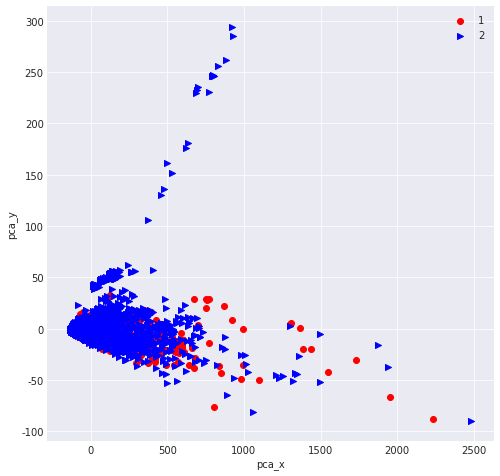

In [99]:
#画图 
kind = np.unique(df['label'].values)
#降维后的结果
plt.figure(figsize=(8, 8))
for i,c,m in zip(range(len(kind)),['r','b','g','y'],['o','>','^','<']):
    index = df[df['label']==kind[i]].index
    x = newvector[index,0]
    y = newvector[index,1]
    plt.scatter(x,y,c=c,marker=m,label=kind[i])
plt.legend()
plt.xlabel('pca_x')
plt.ylabel('pca_y')


### 2.5 K-Means聚类模型训练

在降维的数据上使用K-means聚类算法将数据聚成3类，
这里的3类是事先人工指定的划分群数，
通常是结合后续的业务需要或是结合业务专家的建议凭经验指定，

或者是指定不同的K值后比较得来。

In [100]:
#此处的主成分维度我们人为设定为3，对于属性较少的数据集，属于常规会选择的维度数，后面也会看到，这个也是出于可以可视化的需求
new_pca = PCA(n_components = 3)
#将设置了维数的模型作用到标准化后的数据集并输出查看
X_pca = new_pca.fit_transform(countvector)
X_pca_frame = pd.DataFrame(X_pca,columns=['pca_1','pca_2','pca_3'])
X_pca_frame.head()


,pca_1,pca_2,pca_3
0,-98.995469,-2.030909,-1.177381
1,-103.829451,-2.763062,0.348144
2,-49.870842,-2.595184,0.050671
3,-101.005641,2.577535,1.023167
4,-33.447741,-6.514417,-0.098906


### 2.6 训练简单模型

In [101]:
#K-means聚类建模
#运行KMeans聚类算法
from sklearn.cluster import KMeans
#此处指定K=12
est = KMeans(n_clusters=3)
est.fit(X_pca)
#获取数据标签值
kmeans_clustering_labels = pd.DataFrame(est.labels_,columns=['cluster'])
#将聚类结果与降维特征数据进行拼接
X_pca_frame = pd.concat([X_pca_frame,kmeans_clustering_labels], axis=1) 
X_pca_frame.head(5)


,pca_1,pca_2,pca_3,cluster
0,-98.995469,-2.030909,-1.177381,0
1,-103.829451,-2.763062,0.348144,0
2,-49.870842,-2.595184,0.050671,0
3,-101.005641,2.577535,1.023167,0
4,-33.447741,-6.514417,-0.098906,0


### 2.7 聚类结果分析

查看降维数据

In [102]:
#1)主成分
new_df = pd.DataFrame(countvector)
components_frame = pd.DataFrame(new_pca.components_,index=[u'主成分1',u'主成分2',u'主成分3'],columns=new_df.columns)
#2）降维数据和聚类初步结果
# X_full.groupby('cluster').describe()
components_frame

,0,1,2,3,4,5,6,7,8,9,...,45288,45289,45290,45291,45292,45293,45294,45295,45296,45297
主成分1,0.684770,0.684770,0.000007,0.000001,-0.000005,0.000005,0.000003,-3.318017e-07,4.013193e-08,5.003048e-07,...,0.000005,0.000007,1.027794e-06,8.951313e-07,-5.763272e-07,-2.214396e-07,-2.214396e-07,-2.214396e-07,-8.644909e-07,-5.763272e-07
主成分2,0.012691,0.012691,0.000086,-0.000017,-0.000016,-0.000027,-0.000016,-4.824176e-07,1.518594e-07,2.199787e-05,...,0.000010,0.000017,-3.953863e-09,3.935804e-06,-1.535895e-06,-2.571068e-06,-2.571068e-06,-2.571068e-06,-2.303843e-06,-1.535895e-06
主成分3,0.075929,0.075929,0.000164,0.000007,-0.000022,-0.000008,0.000015,-1.303399e-06,3.260114e-06,7.303474e-06,...,0.000814,0.001071,1.571948e-04,1.532215e-04,1.295758e-05,1.902269e-06,1.902269e-06,1.902269e-06,1.943636e-05,1.295758e-05


In [117]:
# 上传到OBS和本地

#将DataFrame存储为csv,index表示是否显示行名，default=True
components_frame.to_csv("./results/components_frame.csv",index=False,sep=',') 
print('Successfully saved!')

session.upload_data(bucket_path=OBS_BASE_PATH + '/Spy/results/', path='results/components_frame.csv')

Successfully saved!
Successfully upload file results/components_frame.csv to OBS askiksa/Spy/results


In [116]:
X_pca_frame.groupby('cluster').describe()

pca_1                                                              \
          count        mean         std         min         25%         50%   
cluster                                                                       
0        7162.0  -78.649677   39.277399 -132.692681 -110.723042  -88.503776   
1         553.0  584.191443  238.588685  351.350297  466.814347  556.379610   
2        2031.0  118.282185   76.661562   20.070234   55.582807  103.700209   

                                   pca_2            ...             \
                75%          max   count      mean  ...        75%   
cluster                                             ...              
0        -53.626899    20.349002  7162.0 -1.066853  ...   0.271114   
1        587.831541  2478.771399   553.0 -4.699733  ...   0.364431   
2        155.904208   350.640436  2031.0  5.041729  ...  12.406961   

                      pca_3                                            \
                max   count      mean        std        min       25%   
cluster                                                                 
0         42.968693  7162.0 -0.245144   2.312159  -8.778951 -1.195399   
1        293.870772   553.0 -1.564845  34.476716 -66.213364 -9.879512   
2         62.571809  2031.0  1.290538  10.216507 -19.942730 -2.479807   

                                         
              50%       75%         max  
cluster                                  
0       -0.397385  0.508245   55.342705  
1       -7.381629 -3.656507  344.397953  
2        0.464217  3.171772  196.588285  

[3 rows x 24 columns]

聚类结果可视化

Text(0.5,0,'Component 3')

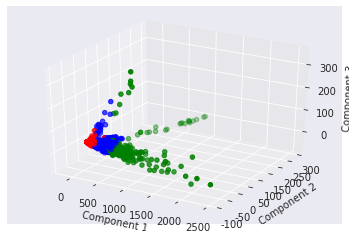

In [105]:
 #绘图
from mpl_toolkits.mplot3d import Axes3D
cluster_1_color = {0:'red',1:'green',2:'blue',3:'yellow',4:'cyan',5:'black',6:'magenta', 7:'#fff0f5', 8:'#ffdab9',9:'#ffa500' }
colors_clustered_data = X_pca_frame['cluster'].map(cluster_1_color)
fig_clustered_data = plt.figure()
ax_clustered_data = fig_clustered_data.add_subplot(111, projection='3d')
ax_clustered_data.scatter(X_pca_frame['pca_1'].values,X_pca_frame['pca_2'].values,X_pca_frame['pca_3'].values,c=colors_clustered_data)
ax_clustered_data.set_xlabel('Component 1')
ax_clustered_data.set_ylabel('Component 2')
ax_clustered_data.set_zlabel('Component 3')


思考

1、分析聚类结果？
2、	无监督学习适应场景？
3、	K-means算法中K的确定有哪些方法？

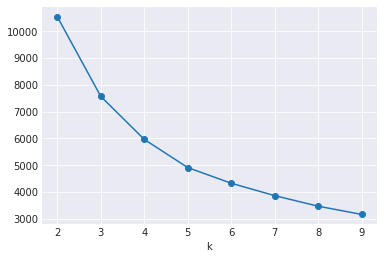

In [106]:
# 肘部法判定K值
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
plotlist = []
for k in range(2,10):
    est = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    plotlist.append(np.sqrt(est.inertia_))

plt.plot(range(2,10),plotlist,'o-')
plt.xlabel('k')
plt.show()


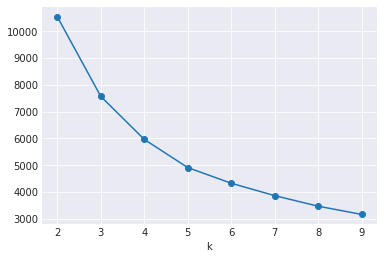

In [107]:
# 轮廓系数法

from sklearn.metrics import silhouette_score
silscore = []
for k in range(2,10):
    est = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    silscore.append(silhouette_score(X_pca,est.labels_))

plt.plot(range(2,10),plotlist,'o-')
plt.xlabel('k')
plt.show()

可以看到当**k=2**的时候达到了比较好的聚类结果，与给出的测试相符

测试数据中一部分是以“疫苗”为关键词，一部分是以“新冠”为关键词，随机打乱得到的结果，这里可以看到，二维的结果比三维聚类的效果好，二维效果相对明显

